# Stacking
### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

### Create Dataframe

In [2]:
selected_features = pd.read_csv('data/selected_features.csv')
target_column = 'price actual'
y = selected_features[target_column]

Remove unwanted columns

In [3]:
try: 
    selected_features.drop(target_column, axis=1, inplace=True)
except:
    print('Already dropped')

### Stacking Function

In [4]:
def Stacking(model, train, y, test, n_fold):
    folds = KFold(n_splits=n_fold)
    test_pred = np.empty((0, test.shape[0]), float)
    train_pred = np.empty((0), float)
    
    for train_indices, val_indices in folds.split(train):
        x_train, x_val = train.iloc[train_indices], train.iloc[val_indices]
        y_train, y_val = y.iloc[train_indices], y.iloc[val_indices]
        
        model.fit(X=x_train, y=y_train)
        train_pred = np.append(train_pred, model.predict(x_val))
        test_pred = np.vstack([test_pred, model.predict(test)])

    test_pred = test_pred.mean(axis=0).reshape(-1, 1)
    
    return test_pred, train_pred

### Hyperparameter tuning

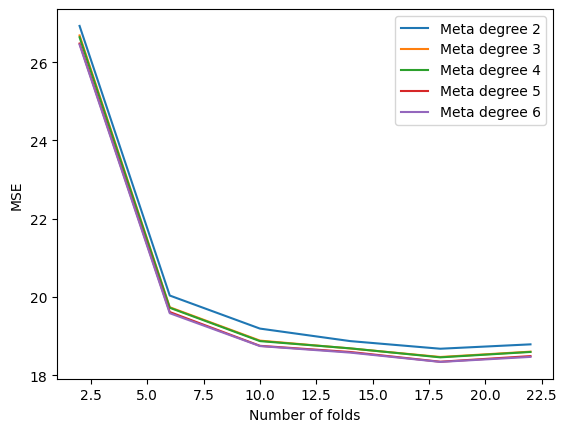

In [6]:
x = selected_features[selected_features.columns]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

mse_list = []
for meta_degree in range(2,7):
    mse_list.append([])
    for n_fold in range(2,25,4):
        model1 = RandomForestRegressor(random_state=42)
        test_pred1 ,train_pred1 = Stacking(model=model1, n_fold=n_fold, train=x_train, test=x_test, y=y_train)
        train_pred1 = pd.DataFrame(train_pred1)
        test_pred1 = pd.DataFrame(test_pred1)

        model2 = DecisionTreeRegressor(random_state=42)
        test_pred2, train_pred2 = Stacking(model=model2, n_fold=n_fold, train=x_train, test=x_test, y=y_train)
        train_pred2 = pd.DataFrame(train_pred2)
        test_pred2 = pd.DataFrame(test_pred2)

        df = pd.concat([train_pred1, train_pred2], axis=1)
        df_test = pd.concat([test_pred1, test_pred2], axis=1)
        meta_model = make_pipeline(PolynomialFeatures(meta_degree), LinearRegression())
        meta_model.fit(df, y_train)
        y_pred = meta_model.predict(df_test)
        
        mse = mean_squared_error(y_test, y_pred)
        mse_list[meta_degree-2].append(mse)

plt.plot(range(2,25,4), mse_list[0], label=f'Meta degree 2')
plt.plot(range(2,25,4), mse_list[1], label=f'Meta degree 3')
plt.plot(range(2,25,4), mse_list[2], label=f'Meta degree 4')
plt.plot(range(2,25,4), mse_list[3], label=f'Meta degree 5')
plt.plot(range(2,25,4), mse_list[4], label=f'Meta degree 6')
plt.xlabel('Number of folds')
plt.ylabel('MSE')
plt.legend()
plt.show()

### Optimal Hyperparameters

Mean Squared Error (MSE): 18.345343648595733


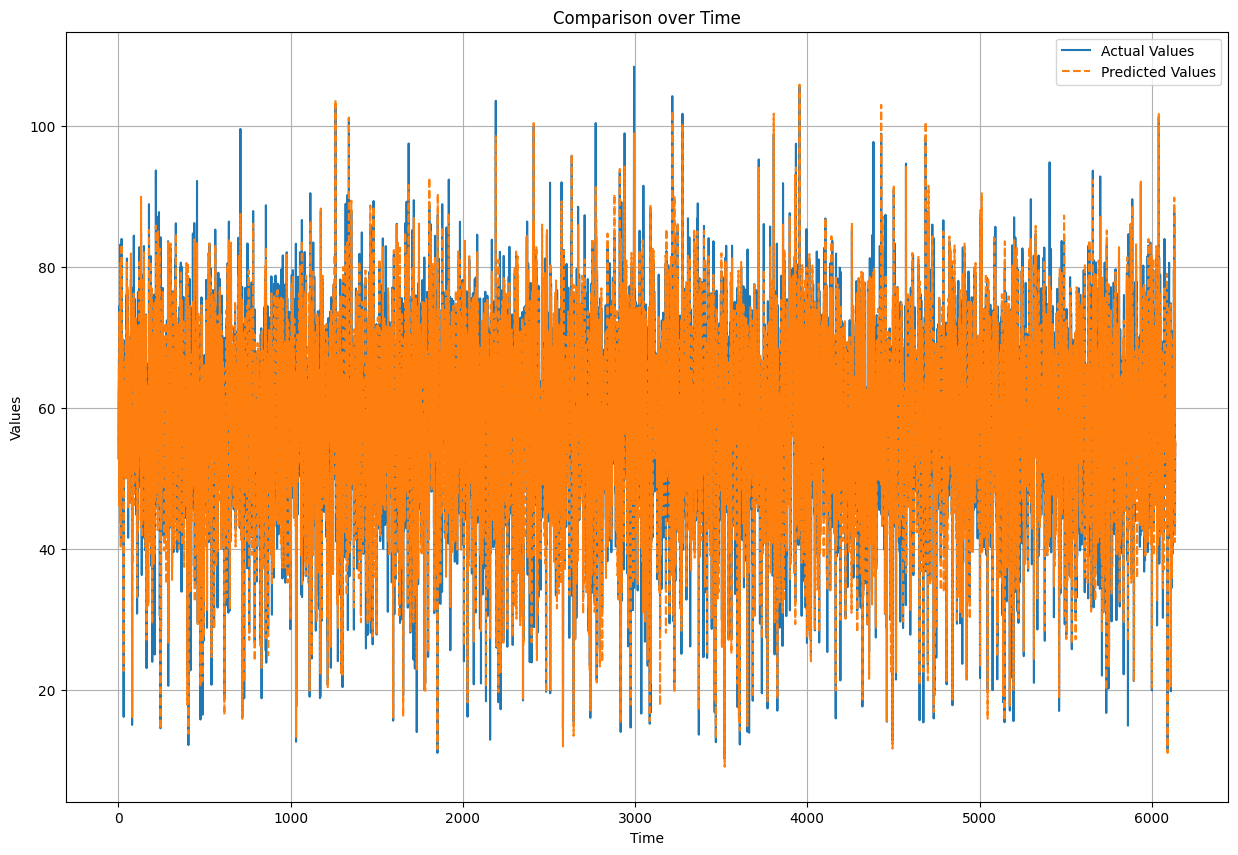

In [5]:
x = selected_features[selected_features.columns]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model1 = RandomForestRegressor(random_state=42)
test_pred1 ,train_pred1 = Stacking(model=model1, n_fold=18, train=x_train, test=x_test, y=y_train)
train_pred1 = pd.DataFrame(train_pred1)
test_pred1 = pd.DataFrame(test_pred1)

model2 = DecisionTreeRegressor(random_state=42)
test_pred2, train_pred2 = Stacking(model=model2, n_fold=18, train=x_train, test=x_test, y=y_train)
train_pred2 = pd.DataFrame(train_pred2)
test_pred2 = pd.DataFrame(test_pred2)

df = pd.concat([train_pred1, train_pred2], axis=1)
df_test = pd.concat([test_pred1, test_pred2], axis=1)
meta_model = make_pipeline(PolynomialFeatures(5), LinearRegression())
meta_model.fit(df, y_train)
y_pred = meta_model.predict(df_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

plt.figure(figsize=(15, 10))
plt.plot(y_test.reset_index(drop=True), label='Actual Values')
plt.plot(y_pred, label='Predicted Values', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Comparison over Time')
plt.legend()
plt.grid(True)
plt.show()

### Test Model on OG Data

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


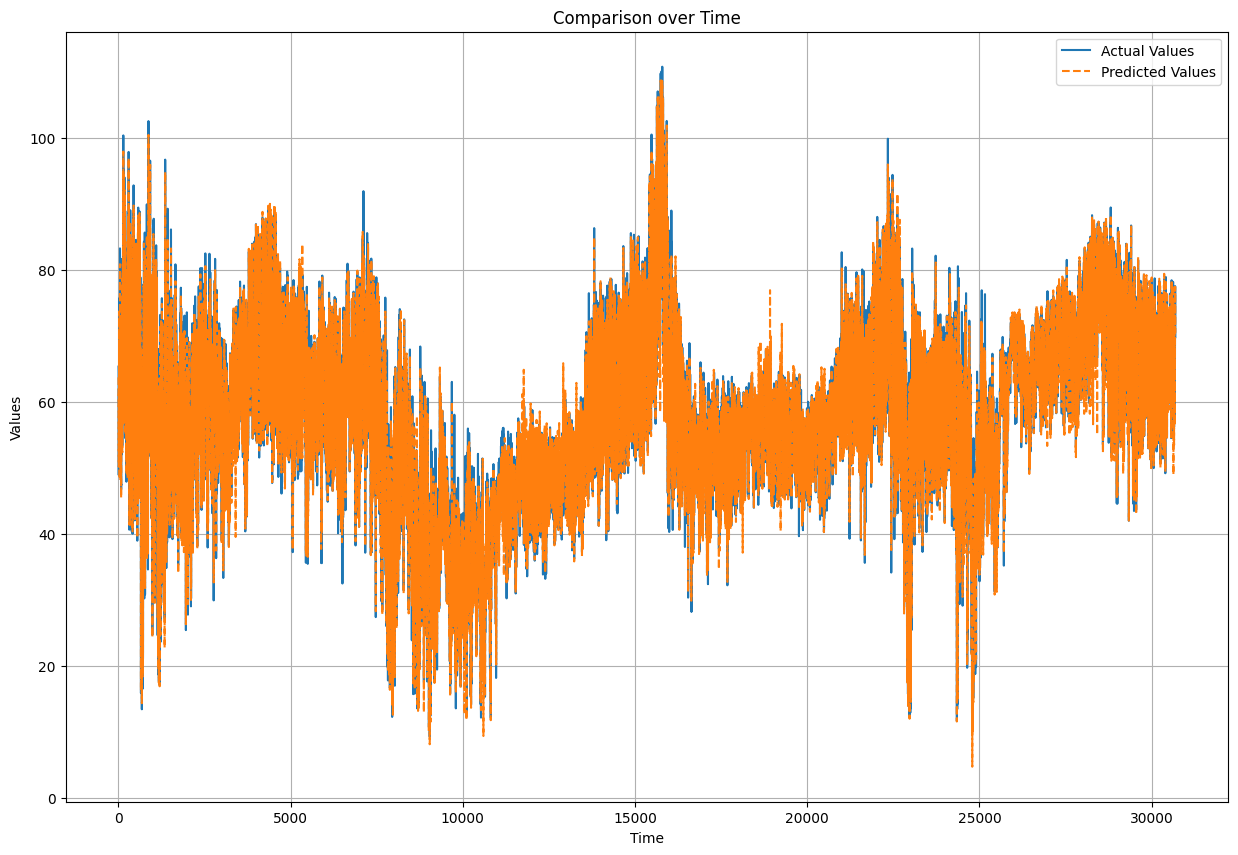

In [6]:
test_pred1 = model1.predict(selected_features)
test_pred2 = model2.predict(selected_features)
df_original = pd.DataFrame({'Model1': test_pred1, 'Model2': test_pred2})
y_pred_total = meta_model.predict(df_original)

plt.figure(figsize=(15, 10))
plt.plot(y, label='Actual Values')
plt.plot(y_pred_total, label='Predicted Values', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Comparison over Time')
plt.legend()
plt.grid(True)
plt.show()

### Save to CSV

In [7]:
stacking = pd.DataFrame(y_pred)
stacking.to_csv('data/stacking.csv', index=False, header=False)